# Trích xuất features cho dữ liệu chuỗi bằng thư viện tsfresh

**BS. Lê Ngọc Khả Nhi**

# Dẫn nhập

Đây là bài thực hành thuộc dự án "Phân tích tín hiệu sinh học" của nhóm Khoa học Dữ liệu Y sinh. Trong bài này, Nhi sẽ giới thiệu với các bạn về thư viện tsfresh, với công dụng trích xuất các thuộc tính của dữ liệu chuỗi, nhằm tạo ra dữ liệu đầu vào cho algorithm Machine learning giải quyết bài toán Phân loại dữ liệu chuỗi, thí dụ Xgboost hay Random Forest.

# Dữ liệu cho thí nghiệm: 

Thí nghiệm của chúng ta dựa trên bộ dữ liệu ECG200 của tác giả R. Olszewski (2001), với mục tiêu là phát hiện nhồi máu cơ tim dựa vào sóng ST trên tín hiệu ECG. Bộ dữ liệu có thể tải về từ link sau: http://www.timeseriesclassification.com/description.php?Dataset=ECG200; hoặc từ github của Nhi:

https://github.com/kinokoberuji/Statistics-Python-Tutorials/tree/master/tsfresh_Demo

Dữ liệu chia riêng thành 2 tập Train và Test, mỗi tập có 100 đoạn tín hiệu ECG với độ dài = 96 giá trị. Tín hiệu đã được xử lý và thang đo đã được chuẩn hóa.

In [1]:
import pandas as pd
import numpy as np

from tsfresh import extract_features
import itertools

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.metrics import *

from xgboost import XGBClassifier # XGboost

%config InlineBackend.figure_format = 'png'

from tqdm import tqdm

In [2]:
train_ts = np.loadtxt('ECG200_TRAIN.txt')
test_ts = np.loadtxt('ECG200_TEST.txt')

Nhi dùng numpy để tải 2 tập dữ liệu, chúng có cấu trúc numpy array 2D (j,n) với j = 100 tương ứng 100 đoạn tín hiệu, mỗi đoạn có kích thước n-1 = 96, vì giá trị đầu tiên dùng để ghi label, với quy ước -1 là âm tính (bình thường), 1 là dương tính (nhồi máu).

Tập train có 31 đoạn Negative và 69 đoạn Positive

In [3]:
train_ts.shape, test_ts.shape

((100, 97), (100, 97))

In [5]:
pd.Series(train_ts[:,0]).value_counts()

 1.0    69
-1.0    31
dtype: int64

# Thăm dò trực quan

Trước hết, ta cùng quan sát 100 đoạn dữ liệu trong tập train, được tô màu theo Label của chúng. Màu đỏ là những đoạn Positive.

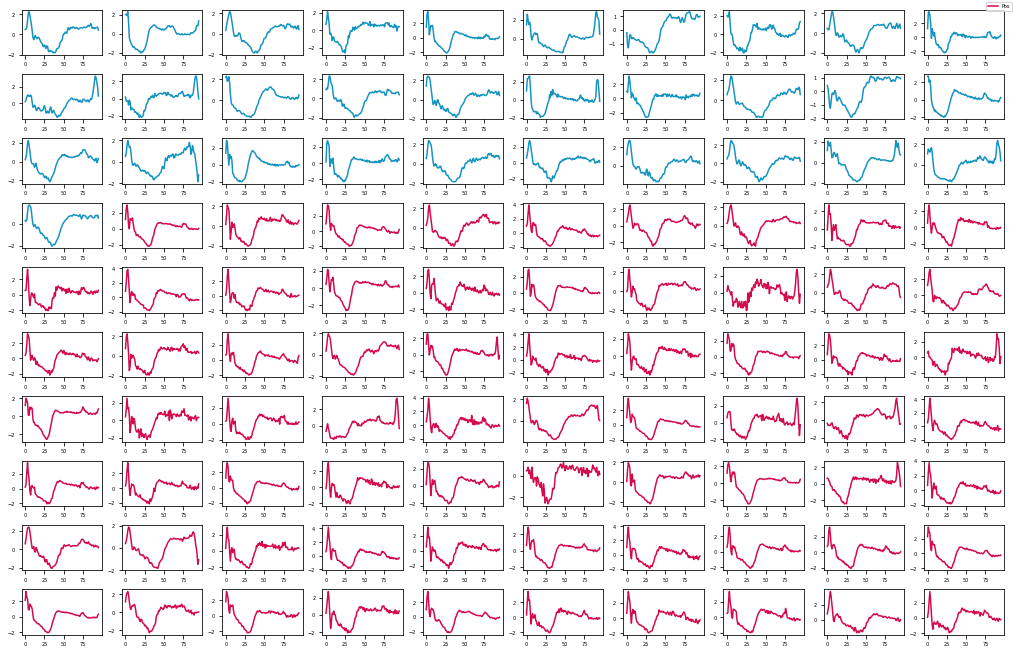

In [4]:
col_dict = {-1: '#1594c2', 1 : '#d40b4a'}
lab_dict = {-1: 'Neg', 1 : 'Pos'}

sorted_mat = pd.DataFrame(train_ts).sort_values(by = 0).to_numpy()

plt.rcParams["figure.figsize"] = (14,9)
plt.rcParams.update({'font.size':5})

fig, axes = plt.subplots(nrows=10, ncols=10)
for i,ax in enumerate(axes.flatten()):
    ax.plot(sorted_mat[i][1:], alpha = 1, 
             color = col_dict[sorted_mat[i][0]],
            label = lab_dict[sorted_mat[i][0]])
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

plt.tight_layout()

Khi chồng lắp lên nhau, ta có hình ảnh như sau:

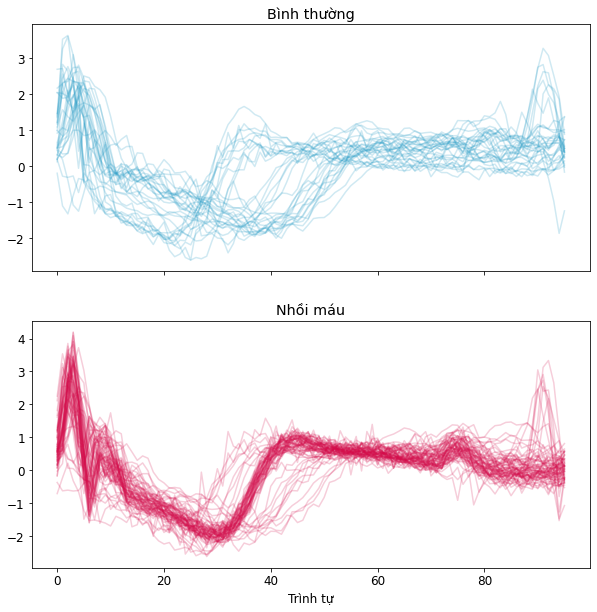

In [6]:
lab_dict = {-1: 'Bình thường', 1 : 'Nhồi máu'}

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size':12})

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey = False)

for ax,lab in zip(axes.flatten(), [-1,1]):
    ax.set(title=lab_dict[lab])
    
    for i in range(100):
        if train_ts[i][0] == lab:
            
            ax.plot(train_ts[i][1:], 
                    color = col_dict[lab], 
                    alpha = 0.2)
            
plt.xlabel('Trình tự')
plt.show()

# Tăng cường dữ liệu bằng cách chèn nhiễu

Tiếp theo, Nhi sẽ dùng một thủ thuật chèn nhiễu trắng (white noise) để tạo ra thật nhiều dữ liệu dùng để huấn luyện mô hình.

Cơ chế của chèn nhiễu như sau: ta dùng 1 hàm để tạo ra white noise theo phân phối Gaussian với trung bình = trung bình của biên độ chuỗi dữ liệu gốc, và sigma = tích của hệ số rho, thí dụ 1.2 và căn bậc 2 của sampling rate, có giá trị tùy chọn thí dụ từ 3-5. Cộng thêm white noise vào chuỗi dữ liệu gốc, ta sẽ có một phiên bản dữ liệu mới có cùng mô thức nhưng biên độ ở mỗi thời điểm ít nhiều khác biệt với chuỗi gốc.

In [7]:
def white_noise(ts: np.array, rho:float, sr:float):
    
    n = ts.shape[0]
    mu = ts.mean()
    sigma = rho * np.sqrt(sr/2)
    noise = np.random.normal(mu, sigma, n)
    return ts + noise

Lấy thí dụ đoạn đầu tiên của tập train, đây là hình ảnh của 30 phiên bản được chèn nhiễu  (màu đỏ) và bản gốc (màu đen).

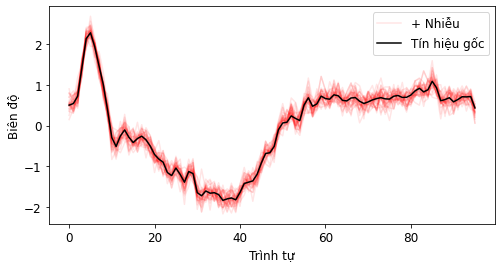

In [8]:
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams.update({'font.size':12})

ts = train_ts[0][1:]

for i in range(30):
    wn = white_noise(ts = ts, 
                     rho = 0.13, 
                     sr = 3)
                 
    if i == 0:
        plt.plot(wn, 'r-', label = '+ Nhiễu', alpha = 0.1)
                 
    plt.plot(wn, 'r-', alpha = 0.1)

plt.plot(ts, 'k-', label = 'Tín hiệu gốc')

plt.legend()
plt.xlabel('Trình tự')
plt.ylabel('Biên độ')
plt.show()

Còn đây là hình ảnh của 3000 chuỗi dữ liệu sinh ra bằng cách chèn nhiễu từ 100 chuỗi dữ liệu gốc ban đầu (mỗi chuỗi gốc được nhân lên thành 30 phiên bản)

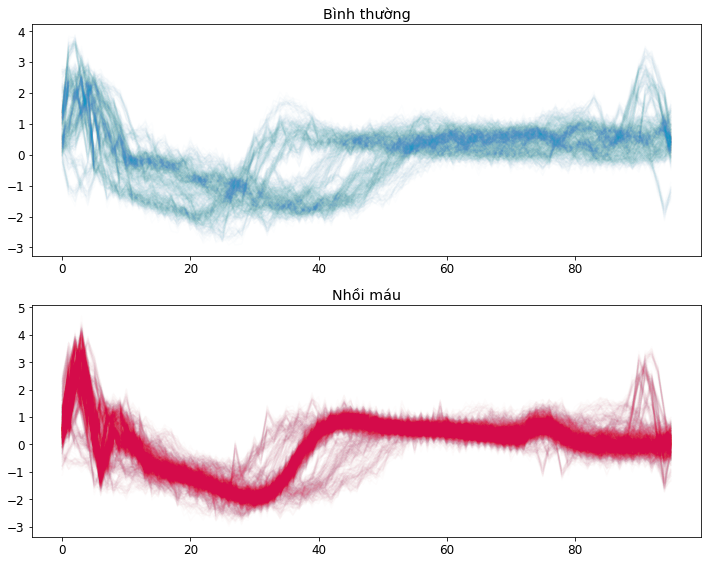

In [9]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size':12})

fig, axes = plt.subplots(nrows=2, ncols=1)


for ax,lab in zip(axes.flatten(), [-1,1]):
    ax.set(title=lab_dict[lab])
    for j in range(30):
        for i in range(100):
            wn = white_noise(ts = train_ts[i][1:], 
                                 rho = 0.12, 
                                 sr = 3)

            if train_ts[i][0] == lab:
                ax.plot(wn, color = col_dict[lab], alpha = 0.01)
                
plt.tight_layout()

Nhi áp dụng kỹ thuật trên để tạo ra một tập dữ liệu train mới có tên là train_noise, trong đó mỗi đoạn tín hiệu gốc được nhân bản lên 50 lần, kết quả ta có đến 5000 đoạn, tập dữ liệu này sẽ được dùng để huấn luyện mô hình

In [10]:
def train_augmentation(ts = None, duplicate = 10):
    temp_ts = ts.copy()
    
    with tqdm(total=duplicate * 100) as pbar:
        for j in range(duplicate):
            nts = ts.copy()
            for i in range(100):
                nts[i,1:] = white_noise(ts = nts[i,1:], 
                                        rho = 0.12, 
                                        sr = 3)
                
                pbar.update(1)
            
            temp_ts = np.vstack([temp_ts, nts])
            
    return temp_ts[100:]

In [11]:
train_noise = train_augmentation(train_ts, duplicate = 50)

train_noise.shape

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 53381.39it/s]


(5000, 97)

# Trích xuất features bằng thư viện tsfresh

Bây giờ diễn viên chính mới ra sân khấu, xin giới thiệu: thư viện tsfresh của 3 tác giả: Maximilian Christ, NilsBraun và JuliusNeuffer, từ năm 2018:

Christ, M., Braun, N., Neuffer, J. and Kempa-Liehr A.W. (2018). Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh -- A Python package). Neurocomputing 307 (2018) 72-77, doi:10.1016/j.neucom.2018.03.067.

Thư viện này cung cấp khoảng 80 hàm để ước tính các trị số thống kê từ dữ liệu chuỗi thời gian (time series data). Khi tổ hợp với các giá trị đối số khác nhau cho mỗi hàm, tsfresh có thể sinh ra từ 1000 đến 3000 features khác nhau cho mỗi chuỗi. Được lập trình bằng ngôn ngữ C và áp dụng tính toán song song trên nhiều CPU, các hàm của tsfresh có tốc độ rất nhanh, cho phép xử lý dữ liệu lớn đến hàng ngàn chuỗi, đa kênh trong thời gian tối ưu. 

Cho mục tiêu trình diễn, Nhi sử dụng 1 cấu hình f_config có dạng dictionary, với 17 hàm, trong đó 1 vài hàm lại nhận tập hợp đối số khác nhau, để khi phối hợp chung sẽ tính ra được 41 features từ mỗi đoạn tín hiệu ECG độ dài 96.

Sau đó, ta chuẩn bị 1 dataframe có cấu trúc 3 cột ID, t và ts, cột ID là mã số định danh cho mỗi chuỗi, t là thời gian từ 0-96, ts là giá trị biên độ tại mỗi thời điểm t. Sau đó dùng hàm extract_features của tsfresh để tạo features theo cấu hình f_config.

In [12]:
f_config = {"minimum":None,
             "maximum":None,
             "mean_abs_change": None,
             "variance": None,
             "absolute_sum_of_changes":None,
            "sample_entropy":None,
            "binned_entropy": [{'max_bins': 60}, 
                               {'max_bins': 30},
                               {'max_bins': 10},
                              ],
            
            "agg_autocorrelation": [{"f_agg":"var","maxlag":60},
                                  {"f_agg":"std","maxlag":60},
                                  {"f_agg":"var","maxlag":30},
                                  {"f_agg":"std","maxlag":30},
                                   {"f_agg":"var","maxlag":10},
                                  {"f_agg":"std","maxlag":10},
                                  ],
            
            "cid_ce": [{'normalize': False}],
            
            "agg_linear_trend": [{"attr": "stderr", 
                                  "chunk_len":10, 
                                  "f_agg": "mean"}],
            
            "approximate_entropy":[{"m": 2, "r":0.1},
                                       {"m": 2, "r":0.3},
                                       {"m": 2, "r":0.5},
                                       {"m": 2, "r":0.7},
                                       {"m": 2, "r":0.9}],
            
            "index_mass_quantile": [{"q": 0.75},
                                   {"q": 0.25},
                                    {"q": 0.95},
                                    {"q": 0.05},
                                   ],
            
            "change_quantiles":[{"f_agg": "std", "isabs":False,"qh":0.5,"ql":0.05},
                              {"f_agg": "mean", "isabs":False,"qh":0.5,"ql":0.05},
                               {"f_agg": "std", "isabs":False,"qh":0.95,"ql":0.5},
                              {"f_agg": "mean", "isabs":False,"qh":0.95,"ql":0.5},
                              ],
            
             "quantile":[{"q":0.05},
                      {"q":0.1},
                      {"q":0.25},
                       {"q":0.75},
                       {"q":0.9},
                       {"q":0.95}],
            
            "linear_trend": [{'attr': 'rvalue'},
                           {'attr': 'slope'},
                            {'attr': 'stderr'},
                           ],
            
            "median":None,
            "mean": None,            
           }

In [13]:
def feature_extraction(ts_data:np.array, 
                       dt:int, 
                       n:int):
    
    ts = np.hstack([np.arange(dt) for i in range(n)])
    X = np.hstack([ts_data[i][1:] for i in range(n)])
    y = pd.Series([ts_data[i][0] for i in range(n)]).map({-1:0,1:1})
    idx = np.repeat(np.arange(n), dt)
    
    ts_df = pd.DataFrame({'ID': idx,
                          't': ts,
                          'ts': X}
                        )
    
    extracted_features = extract_features(ts_df, 
                                          column_id="ID", 
                                          column_sort="t",
                                          n_jobs=16,
                                          default_fc_parameters = f_config
                                         )
    
    return ts_df, extracted_features, y

Áp dụng quy trình này cho lần lượt tập train, tập train_noise và tập test, ta thu được kết quả sau:

In [14]:
_, X_train, y_train = feature_extraction(ts_data = train_ts, 
                                            dt = 96, 
                                            n = 100)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.67it/s]


In [15]:
_, X_train2, y_train2 = feature_extraction(ts_data = train_noise, 
                                        dt = 96, 
                                        n = train_noise.shape[0])

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 80/80 [00:10<00:00,  7.44it/s]


In [16]:
_, X_test, y_test = feature_extraction(ts_data = test_ts, dt = 96, n = 100)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.39it/s]


Dataframe features có cấu trúc n hàng x k cột, với n là số chuỗi, k là số features tạo ra:

In [17]:
X_train

,ts__minimum,ts__maximum,ts__mean_abs_change,ts__variance,ts__absolute_sum_of_changes,ts__sample_entropy,ts__binned_entropy__max_bins_60,ts__binned_entropy__max_bins_30,ts__binned_entropy__max_bins_10,"ts__agg_autocorrelation__f_agg_""var""__maxlag_60",...,ts__quantile__q_0.1,ts__quantile__q_0.25,ts__quantile__q_0.75,ts__quantile__q_0.9,ts__quantile__q_0.95,"ts__linear_trend__attr_""rvalue""","ts__linear_trend__attr_""slope""","ts__linear_trend__attr_""stderr""",ts__median,ts__mean
0,-1.838697,2.281149,0.147462,0.989583,14.008912,0.271553,3.263629,2.779698,1.977263,0.276489,...,-1.626567,-0.842865,0.689683,0.867375,1.173844,0.333444,0.011970,0.003491,0.488525,2.187500e-09
1,-2.130021,2.734889,0.462241,0.989583,43.912926,1.002468,3.595292,3.000179,2.020430,0.100643,...,-1.344496,-0.724425,0.691043,1.098197,1.350405,0.330435,0.011862,0.003495,0.060195,2.031250e-09
2,-2.056372,1.759558,0.127543,0.989583,12.116571,0.303360,3.427906,2.918265,2.028461,0.272845,...,-1.646320,-0.852950,0.750497,0.821589,1.089850,0.369867,0.013277,0.003440,0.464162,-1.635417e-09
3,-1.869313,2.136488,0.157716,0.989583,14.983046,0.248093,3.410500,2.982430,1.985095,0.208874,...,-1.597060,-0.615375,0.460742,1.279896,1.749983,0.170182,0.006109,0.003649,0.203566,-2.427083e-09
4,-1.994453,3.455716,0.230926,0.989583,21.937995,0.635989,3.318709,2.756132,1.758742,0.133030,...,-1.537459,-0.686809,0.597978,0.889196,1.011485,0.110707,0.003974,0.003680,0.273866,3.124997e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.975246,2.541399,0.158550,0.989583,15.062261,0.450201,3.389888,2.905054,1.971720,0.264411,...,-1.455812,-0.837308,0.721908,0.951371,1.049653,0.260538,0.009353,0.003575,0.411686,7.500000e-10
96,-1.998631,2.708703,0.155244,0.989583,14.748167,0.375951,3.322783,2.848035,1.867049,0.101963,...,-1.612133,-0.277993,0.598979,0.948198,1.261833,0.190425,0.006836,0.003635,0.127046,-2.859375e-09
97,-2.179838,2.259463,0.164690,0.989583,15.645539,0.370219,3.404402,2.962661,2.006083,0.210976,...,-1.582453,-0.649623,0.613646,0.961642,1.261498,0.387544,0.013912,0.003413,0.411640,1.411042e-09
98,-2.078231,2.705141,0.261414,0.989583,24.834349,0.680877,3.278538,2.691769,1.749769,0.146500,...,-1.617808,-0.755773,0.589866,0.856198,1.008696,0.392337,0.014084,0.003406,0.418487,1.381250e-09


Như vậy, mỗi features trở thành 1 đại lượng cho phép mô tả hành vi của chuỗi tín hiệu, tập hợp features ta vừa tạo là 1 dữ liệu cấu trúc, tương thích với những algorithm machine learning cổ điển.

Đây là cách mà các data scientist giải quyết bài toán phân loại tín hiệu sinh học mà không dùng cách tiếp cận Deep learning.

Ta có thể mô tả trực quan 40 features và nhận thấy rằng chúng cho ra hình ảnh tương phản khá rõ giữa 2 Labels:

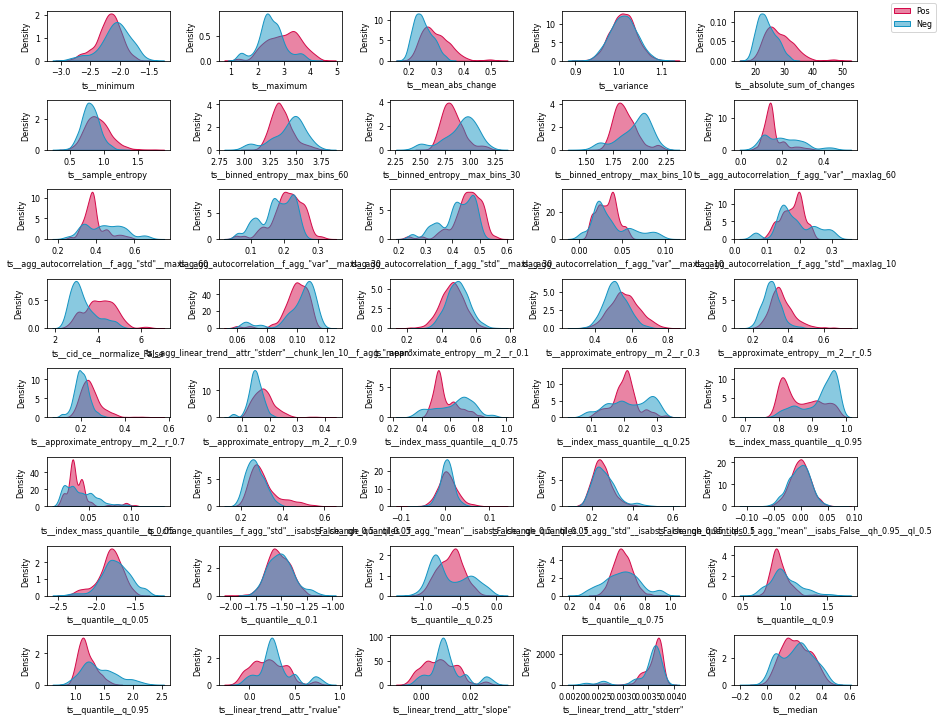

In [18]:
plt.rcParams["figure.figsize"] = (12,10)
plt.rcParams.update({'font.size':8})

fig, axes = plt.subplots(nrows=8, ncols=5)

for i,ax in enumerate(axes.flatten()):
    
    neg_df = X_train2[y_train2 == 0]
    pos_df = X_train2[y_train2 == 1]
    k = X_train2.columns[i]
    
    sns.kdeplot(data = pos_df[k], 
                shade = True, 
                color = '#d40b4a', 
                label = 'Pos',
                alpha = 0.5, 
                ax=ax)
    
    sns.kdeplot(data = neg_df[k], 
                shade = True,
                label = 'Neg',
                color = '#1594c2', 
                alpha = 0.5, 
                ax=ax)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

plt.tight_layout()

# Huấn luyện mô hình Machine learning với features data

Bây giờ là lúc ta hưởng thành quả mà tfresh mang lại, Nhi sẽ huấn luyện một mô hình nhị phân bằng xgboost cho bài toán này. Dữ liệu đầu vào là 41 features mà tsfresh tạo ra:

Trước hết, Nhi dùng kỹ thuật SMOTE để oversampling, cân bằng tỉ lệ 2 nhãn Positive/Negative cho 2 tập train và train2 (từ dữ liệu tăng cường chèn nhiễu). SMOTE giải quyết khá tốt vấn đề label imbalance và làm cho mô hình chính xác hơn.

In [34]:
from imblearn.over_sampling import SMOTE

ros = SMOTE()

X_train, y_train = ros.fit_resample(X_train, y_train)
# X_train2, y_train2 = ros.fit_resample(X_train2, y_train2)

Nhi huấn luyện một mô hình xgboost nhị phân trên các tập features train2 và train:

In [43]:
xgb_mod = XGBClassifier(booster='dart',
                        learning_rate = 0.05,
                        n_estimators = 1000,
                        subsample = 0.7,
                        colsample_bytree = 0.35,
                        tree_method = "gpu_hist",
                        gpu_id = 0,
                        max_depth = 7,
                        eval_metric = 'logloss',
                        predictor = 'gpu_predictor',
                       use_label_encoder=False)

xgb_mod.fit(X = X_train2, 
            y = y_train2, 
            eval_set = [(X_train, y_train)],
            early_stopping_rounds=10,
            eval_metric="logloss",
            verbose = False)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35, eval_metric='logloss',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Kiểm định độc lập mô hình phân loại

Sau khi mô hình huần luyện xong, ta kiểm tra hiệu năng của nó trên tập feature test:

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(6,6))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Sự thật')
    plt.xlabel('Dự báo')
    plt.show()


def Performance(Model = None, X=None, Y=None, labels =['Neg','Pos']):
    
    pred = Model.predict(X)
    truth = Y    
    y_scores = Model.predict_proba(X)
    
    cnf_matrix = confusion_matrix(truth,pred)

    TN,FP,FN,TP = cnf_matrix.ravel()
    TPR=TP/(TP+FN)
    TNR=TN/(TN+FP)
    LRpos=TPR/(1-TNR)
    LRneg=(1-TPR)/TNR
        
    plot_confusion_matrix(cnf_matrix,
                      classes= labels, 
                      normalize=True,
                      title='Ma trận nhầm lẫn')
    
    plt.show()
    
    return pd.DataFrame({'Độ nhạy': TPR,
                        'Đặc hiệu': TNR,
                         'Chính xác': (TP + TN)/(TP + TN + FP + FN),
                         'F1': f1_score(y_true = truth,y_pred = pred, average='macro'),
                         'BAC': (TPR+TNR)/2,
                         'Giá trị tiên đoán +': TP/(TP+FP),
                         'Giá trị tiên đoán -': TN/(TN+FN),
                         'Tỉ số khả dĩ +': TPR/(1-TNR),
                         'Tỉ số khả dĩ -':(1-TPR)/TNR,
                         'ROC_AUC': roc_auc_score(truth, y_scores[:,1])
                        }, index = ['Hiệu năng']).T

Normalized confusion matrix
[[0.80555556 0.19444444]
 [0.125      0.875     ]]


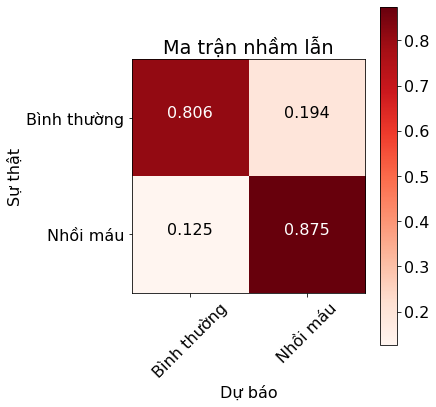

,Hiệu năng
Độ nhạy,0.875000
Đặc hiệu,0.805556
Chính xác,0.850000
F1,0.838205
BAC,0.840278
Giá trị tiên đoán +,0.888889
Giá trị tiên đoán -,0.783784
Tỉ số khả dĩ +,4.500000
Tỉ số khả dĩ -,0.155172
ROC_AUC,0.927083


In [45]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size':10})

Performance(Model = xgb_mod, 
            X = X_test, 
            Y = y_test,
            labels =['Bình thường','Nhồi máu'])

In [46]:
def Boot_ROCcurve(Model = None, 
                  X=None, 
                  Y=None,
                  n_iter = 1000):
    
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    valid_df = pd.DataFrame({'Truth': Y,
                             'Pred': Model.predict(X),
                             'Score': Model.predict_proba(X)[:,1]}, 
                            index = Y.index)
    
    for i in range(n_iter):
        # bootstrap by sampling with replacement
        resamp_df = valid_df.sample(1000, replace=True)
        
        if len(np.unique(resamp_df['Pred'])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
            
        fpr, tpr, _ = roc_curve(resamp_df['Truth'], resamp_df['Score'])
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_up = np.minimum(mean_tprs + 1.645*std, 1)
    tprs_low = mean_tprs - 1.645*std
        
    plt.rcParams["figure.figsize"] = (7,6.6)
    plt.rcParams.update({'font.size': 15})

    plt.plot(base_fpr, mean_tprs, 'r', 
             alpha = 1, 
             label=r'AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),)
    
    plt.fill_between(base_fpr, 
                     tprs_low, tprs_up, 
                     color = 'red', alpha = 0.3)
    
    plt.plot([0, 1], [0, 1], 
             linestyle = '--', 
             lw = 2, 
             color = 'grey', 
             label = 'Ngẫu nhiên', 
             alpha= 0.5)
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    
    plt.ylabel('Tỉ lệ dương tính thật')
    plt.xlabel('Tỉ lệ dương tính giả')
    plt.legend(loc="lower right")
    plt.title('Đường cong ROC')

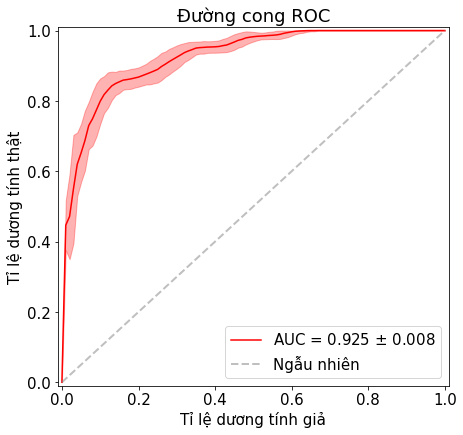

In [47]:
Boot_ROCcurve(Model = xgb_mod, 
              X=X_test, 
              Y=y_test, 
              n_iter = 100)

Kết quả cho thấy dù chỉ dùng 41 features, ta thu được 1 mô hình phân loại có độ chính xác khá cao với F1 = 0.838 và BAC = 0.84, AUC = 0.925.

# Cấu hình mặc định của tsfresh

Khi không thiết lập configuration, tsfresh sẽ tự động tạo ra đến 779 features, ta sẽ thử dựng một mô hình khác với dữ liệu này

In [69]:
def feature_extraction_2(ts_data:np.array, 
                            dt:int, 
                            n:int):
    
    ts = np.hstack([np.arange(dt) for i in range(n)])
    X = np.hstack([ts_data[i][1:] for i in range(n)])
    y = pd.Series([ts_data[i][0] for i in range(n)]).map({-1:0,1:1})
    idx = np.repeat(np.arange(n), dt)
    
    ts_df = pd.DataFrame({'ID': idx,
                          't': ts,
                          'ts': X}
                        )
    
    extracted_features = extract_features(ts_df, 
                                          column_id="ID", 
                                          column_sort="t",
                                          n_jobs=16,
                                         )
    
    return ts_df, extracted_features, y

_, X_train, y_train = feature_extraction_2(ts_data = train_ts, 
                                            dt = 96, 
                                            n = 100)

_, X_train2, y_train2 = feature_extraction_2(ts_data = train_noise, 
                                        dt = 96, 
                                        n = train_noise.shape[0])

_, X_test, y_test = feature_extraction_2(ts_data = test_ts, dt = 96, n = 100)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.34it/s]


In [71]:
X_train.shape, X_train2.shape

((138, 779), (6900, 779))

Với cấu hình mặc định, một số features có thể cho ra giá trị NaN, do đó kỹ thuật SMOTE không thể sử dụng được, thay vào đó ta dùng kỹ thuật Random Over Sampling.

In [70]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train2, y_train2 = ros.fit_resample(X_train2, y_train2)

Ta huấn luyện một mô hình mới:

In [75]:
xgb_mod2 = XGBClassifier(booster='dart',
                        learning_rate = 0.05,
                        n_estimators = 1000,
                        subsample = 0.5,
                        colsample_bytree = 0.3,
                        tree_method = "gpu_hist",
                        gpu_id = 0,
                        max_depth = 7,
                        eval_metric = 'logloss',
                        predictor = 'gpu_predictor',
                       use_label_encoder=False)

xgb_mod2.fit(X = X_train2,
            y = y_train2, 
            eval_set = [(X_train, y_train)],
            early_stopping_rounds=10,
            eval_metric="logloss",
            verbose = False)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Kết quả kiểm định cho thấy mô hình mới đạt độ chính xác cao hơn 1 chút so với mô hình cũ. Giá trị ACC = 0.89 được xem như tương đương với hiệu năng cao nhất mà tác giả đã từng làm trên bộ dữ liệu này.

Normalized confusion matrix
[[0.80555556 0.19444444]
 [0.0625     0.9375    ]]


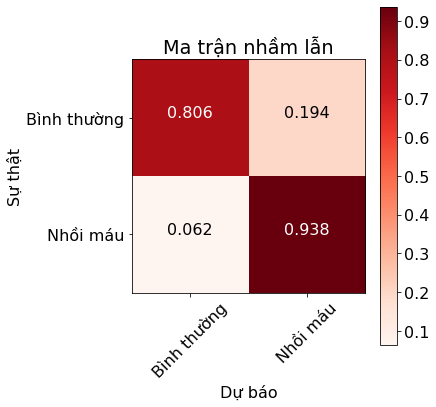

,Hiệu năng
Độ nhạy,0.937500
Đặc hiệu,0.805556
Chính xác,0.890000
F1,0.878305
BAC,0.871528
Giá trị tiên đoán +,0.895522
Giá trị tiên đoán -,0.878788
Tỉ số khả dĩ +,4.821429
Tỉ số khả dĩ -,0.077586
ROC_AUC,0.959635


In [76]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size':10})

Performance(Model = xgb_mod2, 
            X = X_test, 
            Y = y_test,
            labels =['Bình thường','Nhồi máu'])

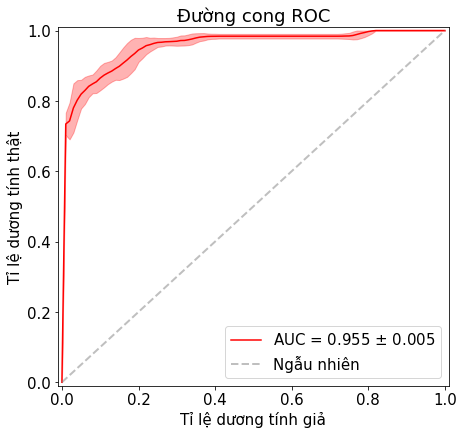

In [77]:
Boot_ROCcurve(Model = xgb_mod2, 
              X=X_test, 
              Y=y_test, 
              n_iter = 100)

# Kết luận

Thư viện tsfresh là một trợ thủ đắc lực để giải quyết các bài toán Machine learning Phân loại dữ liệu chuỗi theo cách làm trích xuất features thủ công. 

Chúc các bạn thực hành vui và hẹn gặp lại.